In [1]:
import os
import re
from lib_log_parse import load_parsed_logs, parse
from typing import Dict, List, Optional
import numpy as np
from lib_constants import log_no_to_region
from model_publication import Publication
from model_retrieval import Retrieval
import multiprocessing as mp
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
from typing import Tuple

sns.set_theme()

In [2]:
def cdf(series: pd.Series) -> pd.DataFrame:
    return pd.DataFrame.from_dict({
        series.name: np.append(series.sort_values(), series.max()),
        "cdf": np.linspace(0, 1, len(series) + 1)
    })

In [3]:
path = "../data/2022-12-02_hydra_dial_down"

In [4]:
values = []
for fn in os.listdir(path):
    file_path = os.path.join(path, fn)
    if not os.path.isfile(file_path):
        continue

    if not fn.endswith(".log"):
        continue

    if os.path.exists(file_path + ".p"):
        print(f"Skipping: {file_path}")
        continue

    # parse = [file_path]
    values += [[file_path]]

with mp.Pool() as pool:
    pool.map(parse, values)

Skipping: ../data/2022-12-02_hydra_dial_down/nodes-list-fleet-1-node-5.log
Skipping: ../data/2022-12-02_hydra_dial_down/nodes-list-fleet-1-node-4.log
Skipping: ../data/2022-12-02_hydra_dial_down/nodes-list-fleet-1-node-6.log
Skipping: ../data/2022-12-02_hydra_dial_down/nodes-list-fleet-1-node-3.log
Skipping: ../data/2022-12-02_hydra_dial_down/nodes-list-fleet-1-node-2.log
Skipping: ../data/2022-12-02_hydra_dial_down/nodes-list-fleet-1-node-0.log
Skipping: ../data/2022-12-02_hydra_dial_down/nodes-list-fleet-1-node-1.log
Skipping: ../data/2022-12-02_hydra_dial_down/nodes-list-fleet-2-node-2.log
Skipping: ../data/2022-12-02_hydra_dial_down/nodes-list-fleet-2-node-3.log
Skipping: ../data/2022-12-02_hydra_dial_down/nodes-list-fleet-2-node-1.log
Skipping: ../data/2022-12-02_hydra_dial_down/nodes-list-fleet-2-node-0.log
Skipping: ../data/2022-12-02_hydra_dial_down/nodes-list-fleet-2-node-4.log
Skipping: ../data/2022-12-02_hydra_dial_down/nodes-list-fleet-2-node-5.log
Skipping: ../data/2022-12

In [5]:
files = []
for fn in os.listdir(path):
    file_path = os.path.join(path, fn)
    if not os.path.isfile(file_path):
        continue

    if not fn.endswith(".log"):
        continue

    files += [file_path]

pool = mp.Pool(mp.cpu_count())
results = pool.map(load_parsed_logs, list(map(lambda x: [x], files)))


In [6]:
def log_origin(origin: str) -> Optional[Tuple[int, int]]:
    match = re.search(r".*\/nodes-list-fleet-(\d)-node-(\d).log", origin)
    if match is None:
        match = re.search(r".*\/nodes-list-ignore-hydras-node-(\d).log", origin)
        if match is None:
            return None
        return 3, int(match.group(1))

    fleet = int(match.group(1))
    node = int(match.group(2))
    return fleet, node


def map_region(fleet: int, node: int) -> str:
    if fleet == 1:
        if node in log_no_to_region:
            return log_no_to_region[node]
        elif node == 6:
            return "hetzner_eu_nbg"
    elif fleet == 2:
        if node in log_no_to_region:
            return log_no_to_region[node]
        elif node == 6:
            return "hetzner_us_ash"
    elif fleet == 3:
        if node in log_no_to_region:
            return log_no_to_region[node]
        elif node == 6:
            return "hetzner_eu_nbg"
        elif node == 7:
            return "hetzner_us_ash"
    raise Exception(f"unknown fleet {fleet} node {node} combination")


def region_from_origin(origin: str) -> str:
    fleet, node = log_origin(origin)
    return map_region(fleet, node)


results_by_region = {}

for idx, f in enumerate(files):
    region = region_from_origin(f)

    if not region in results_by_region:
        results_by_region[region] = []
    results_by_region[region] += [results[idx][0]]

In [7]:
df_retrievals_dict = {
    "fleet": [],
    "node": [],
    "region": [],
    "with_hydras": [],
    "started_at": [],
    "overall_retrieval_duration": [],
    "dht_walks_duration": [],
    "find_first_provider_duration": [],
    "content_fetch_duration": [],
    "find_provider_queries_count": [],
    "has_error": [],
}

In [8]:
publications: List[Publication] = []
retrievals: List[Retrieval] = []
for parsed_log in results:
    for log in parsed_log:
        publications += log.publications
        retrievals += log.retrievals

# Remove all retrievals that are marked as invalid
retrievals = list(
    filter(lambda ret: not ret.marked_as_incomplete, retrievals))
retrievals = list(filter(lambda ret: ret.state != Retrieval.State.DONE_WITHOUT_ASKING_PEERS, retrievals))

for ret in retrievals:
    if ret.stream_opened_at is None or ret.connected_at is None:
        print("skip", ret.stream_opened_at, ret.connected_at)
        continue

    fleet, node = log_origin(ret.origin)
    region = map_region(fleet, node)
    # region = region_from_origin(ret.origin)
    if region is None:
        raise Exception("AHH")

    df_retrievals_dict["started_at"] += [ret.dial_started_at]
    df_retrievals_dict["with_hydras"] += [fleet != 3]
    df_retrievals_dict["fleet"] += [fleet]
    df_retrievals_dict["node"] += [node]
    df_retrievals_dict["region"] += [region]
    df_retrievals_dict["has_error"] += [ret.done_retrieving_error is not None]

    overall_retrieval_duration = (ret.done_retrieving_at - ret.retrieval_started_at).total_seconds()
    # simulate peer record retrieval by adding the DHT walk duration
    overall_retrieval_duration += ret.get_dht_walk_duration()
    df_retrievals_dict["overall_retrieval_duration"] += [overall_retrieval_duration]

    # simulate peer record retrieval by adding the DHT walk duration
    dht_walks_duration = 2 * ret.get_dht_walk_duration()
    df_retrievals_dict["dht_walks_duration"] += [dht_walks_duration]

    df_retrievals_dict["find_first_provider_duration"] += [(
            ret.found_first_provider_at - ret.get_providers_queries_started_at).total_seconds()]
    df_retrievals_dict["content_fetch_duration"] += [(ret.done_retrieving_at - ret.dial_started_at).total_seconds()]
    df_retrievals_dict["find_provider_queries_count"] += [
        len(list(filter(lambda gpq: gpq.started_at > ret.done_retrieving_at, ret.get_providers_queries.values())))]

df_retrievals = pd.DataFrame.from_dict(df_retrievals_dict)

skip None 2022-11-26 01:27:56.673828+00:00
skip None 2022-11-26 03:13:57.461092+00:00
skip None 2022-11-27 09:26:22.142936+00:00
skip None 2022-11-28 03:40:53.378387+00:00
skip None 2022-11-28 03:51:49.151898+00:00
skip None 2022-11-28 21:49:54.634930+00:00
skip None 2022-11-29 09:15:23.821383+00:00
skip None 2022-11-30 04:57:03.082503+00:00
skip None 2022-12-01 07:42:08.747063+00:00
skip None 2022-12-01 21:24:29.975931+00:00
skip None 2022-11-26 13:08:16.063403+00:00
skip None 2022-11-26 16:13:45.958209+00:00
skip None 2022-11-26 19:48:54.547618+00:00
skip None 2022-11-26 20:33:48.770438+00:00
skip None 2022-11-27 08:41:53.912341+00:00
skip None 2022-11-29 06:56:58.477133+00:00
skip None 2022-11-26 20:33:48.931369+00:00
skip None 2022-11-27 08:41:54.222476+00:00
skip None 2022-11-27 12:01:38.543387+00:00
skip None 2022-11-30 04:57:03.006596+00:00
skip None 2022-11-26 02:12:45.173559+00:00
skip None 2022-11-26 23:39:02.658938+00:00
skip None 2022-11-26 17:58:42.174780+00:00
skip None 2

In [ ]:
df_retrievals

/var/folders/5v/11vhc3kx5yxc2kr1whd5hyxc0000gn/T/ipykernel_96722/1007023817.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grp.quantile([.5, .9, .95])


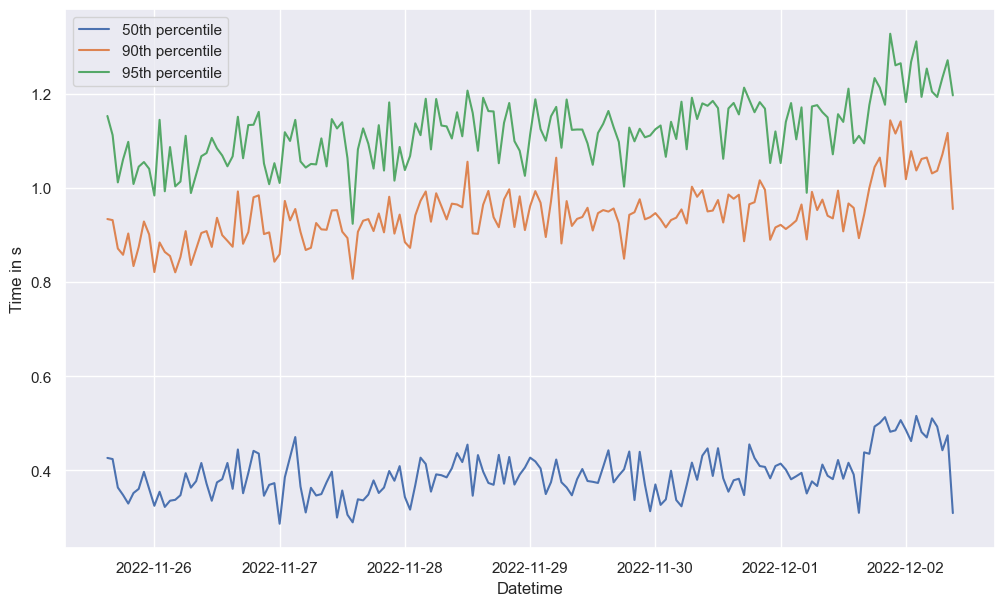

In [9]:
data = df_retrievals[df_retrievals["with_hydras"]]
grp = data.groupby(by=[data.started_at.map(lambda started_at: started_at.replace(minute=0, second=0, microsecond=0))])
grp.find_first_provider_duration.quantile([.5, .9, .95])
df = grp.quantile([.5, .9, .95])
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=[12, 7])

percentiles = [50, 90, 95]
for percentile in percentiles:
    dat = df[df["level_1"] == percentile/100]
    ax.plot(dat["started_at"], dat["find_first_provider_duration"], label=f"{percentile}th percentile")

ax.set_ylabel("Time in s")
ax.set_xlabel("Datetime")
ax.legend()

/var/folders/5v/11vhc3kx5yxc2kr1whd5hyxc0000gn/T/ipykernel_96722/1424404352.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grp.quantile([.5, .9, .95])


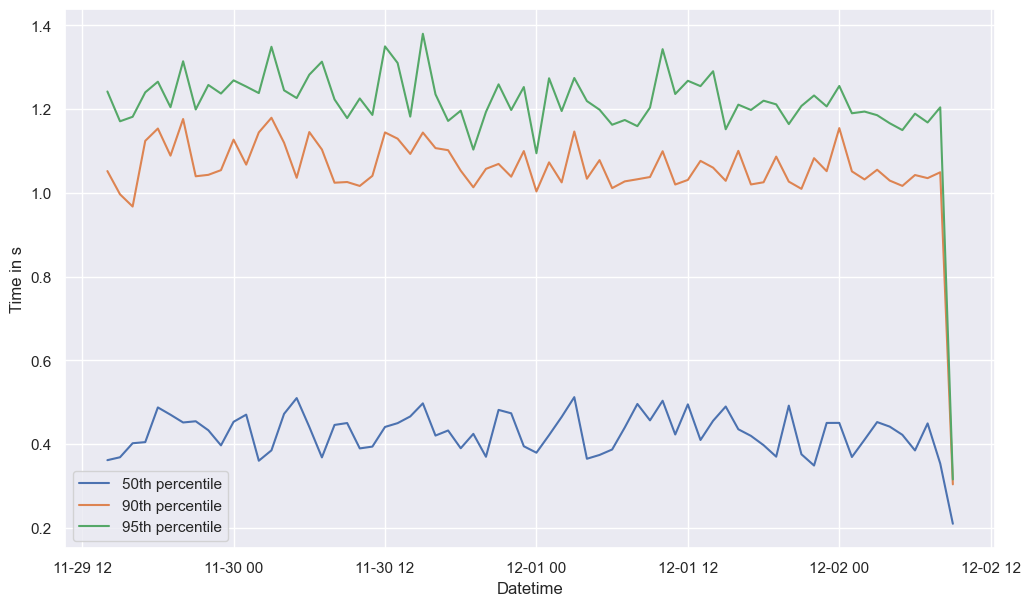

In [10]:
data = df_retrievals[df_retrievals["with_hydras"] == False]
data = data[data["started_at"] > "2022-11-29"]
grp = data.groupby(by=[data.started_at.map(lambda started_at: started_at.replace(minute=0, second=0, microsecond=0))])
grp.find_first_provider_duration.quantile([.5, .9, .95])
df = grp.quantile([.5, .9, .95])
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=[12, 7])

percentiles = [50, 90, 95]
for percentile in percentiles:
    dat = df[df["level_1"] == percentile/100]
    ax.plot(dat["started_at"], dat["find_first_provider_duration"], label=f"{percentile}th percentile")

ax.set_ylabel("Time in s")
ax.set_xlabel("Datetime")
ax.legend()

/var/folders/5v/11vhc3kx5yxc2kr1whd5hyxc0000gn/T/ipykernel_96722/1480036354.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grp.quantile([.5, .9, .95])
/var/folders/5v/11vhc3kx5yxc2kr1whd5hyxc0000gn/T/ipykernel_96722/1480036354.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grp.quantile([.5, .9, .95])


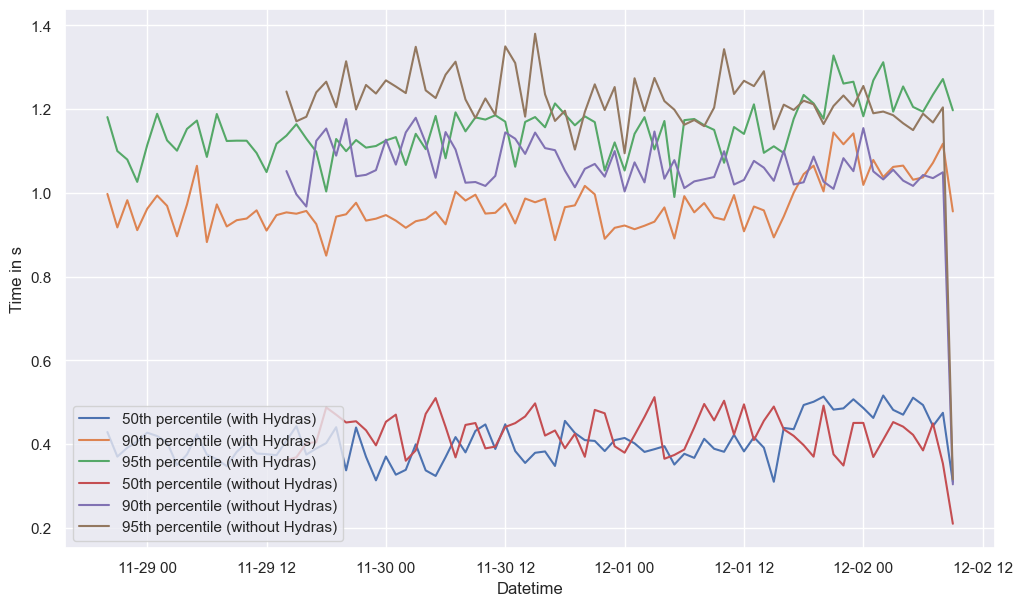

In [14]:
fig, ax = plt.subplots(figsize=[12, 7])

percentiles = [50, 90, 95]

data = df_retrievals[df_retrievals["with_hydras"] == True]
data = data[data["started_at"] > "2022-11-28T20:00"]
grp = data.groupby(by=[data.started_at.map(lambda started_at: started_at.replace(minute=0, second=0, microsecond=0))])
df = grp.quantile([.5, .9, .95])
df.reset_index(inplace=True)

for percentile in percentiles:
    dat = df[df["level_1"] == percentile/100]
    ax.plot(dat["started_at"], dat["find_first_provider_duration"], label=f"{percentile}th percentile (with Hydras)")


data = df_retrievals[df_retrievals["with_hydras"] == False]
grp = data.groupby(by=[data.started_at.map(lambda started_at: started_at.replace(minute=0, second=0, microsecond=0))])
df = grp.quantile([.5, .9, .95])
df.reset_index(inplace=True)
df = df[df["started_at"] > '2022-11-28T20:00']

for percentile in percentiles:
    dat = df[df["level_1"] == percentile/100]
    ax.plot(dat["started_at"], dat["find_first_provider_duration"], label=f"{percentile}th percentile (without Hydras)")

ax.set_ylabel("Time in s")
ax.set_xlabel("Datetime")
ax.legend(loc="lower left")

In [ ]:

after_dial_down = df_retrievals[df_retrievals["with_hydras"] == True]
after_dial_down = after_dial_down[after_dial_down["started_at"] > "2022-12-01T17:30"]
after_dial_down

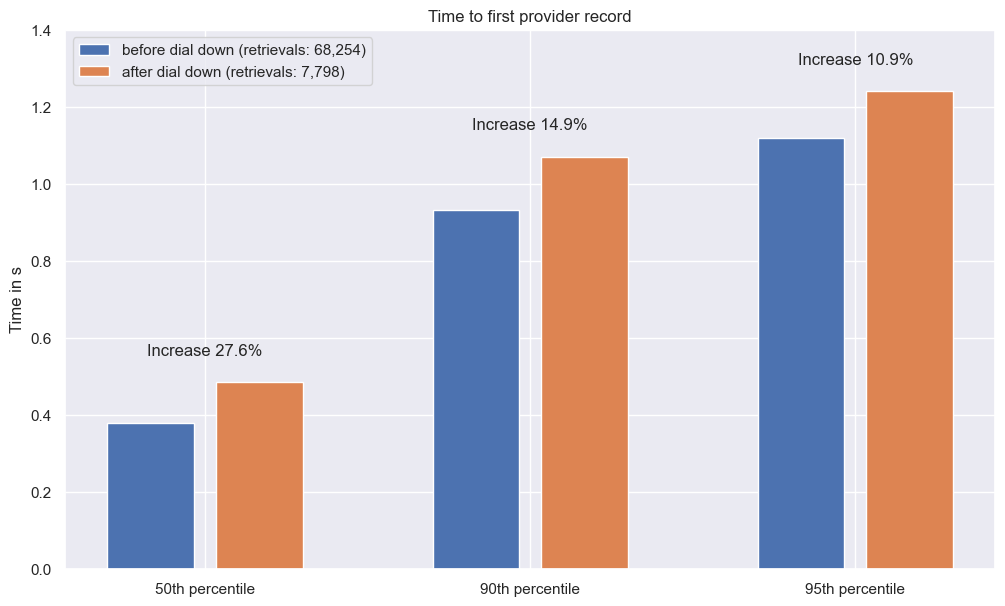

In [17]:
fig, ax = plt.subplots(figsize=[12, 7])

percentiles = [50, 90, 95]

# region = "hetzner_us_ash"

before_dial_down = df_retrievals[df_retrievals["with_hydras"] == True]
# before_dial_down = before_dial_down[before_dial_down["region"] == region]
before_dial_down = before_dial_down[before_dial_down["started_at"] < "2022-12-01T17:30"]

lats_before = []
for j, percentile in enumerate(percentiles):
    lats_before += [np.percentile(before_dial_down["find_first_provider_duration"], percentile)]
ax.bar([0, 3, 6], lats_before, label=f"before dial down (retrievals: {len(before_dial_down):,})")

after_dial_down = df_retrievals[df_retrievals["with_hydras"] == True]
# after_dial_down = after_dial_down[after_dial_down["region"] == region]
after_dial_down = after_dial_down[after_dial_down["started_at"] > "2022-12-01T17:30"]

lats_after = []
for j, percentile in enumerate(percentiles):
    lats_after += [np.percentile(after_dial_down["find_first_provider_duration"], percentile)]
ax.bar([1, 4, 7], lats_after, label=f"after dial down (retrievals: {len(after_dial_down):,})")

ax.text(0.5, np.max(lats_after[0]) + 0.07, f"Increase {100 * (lats_after[0] - lats_before[0]) / lats_before[0]:.1f}%",
        ha="center")
ax.text(3.5, np.max(lats_after[1]) + 0.07, f"Increase {100 * (lats_after[1] - lats_before[1]) / lats_before[1]:.1f}%",
        ha="center")
ax.text(6.5, np.max(lats_after[2]) + 0.07, f"Increase {100 * (lats_after[2] - lats_before[2]) / lats_before[2]:.1f}%",
        ha="center")

ax.set_title(f"Time to first provider record")
ax.set_xticks([0.5, 3.5, 6.5], list(map(lambda p: f"{p}th percentile", percentiles)))
ax.set_ylabel("Time in s")
ax.set_ylim(0, 1.4)
ax.legend(loc="upper left")

In [ ]:
datasets = [
    overall_retrieval_duration_per_region_with_hydras,
    dht_ret_find_first_provider_per_region_with_hydras,
    dht_ret_walks_duration_per_region_with_hydras,
    content_fetch_duration_per_region_with_hydras
]

datasets_labels = ["Overall Retrieval Duration", "Find First Provider Latency", "DHT Walks Duration (two walks!)",
                   "Content Fetch Duration"]

fig, axes = plt.subplots(1, len(datasets), figsize=[24, 5], sharey=True)

regions = list(log_no_to_region.values())
regions = list(sorted(regions))
regions += ["hetzner_eu_nbg", "hetzner_us_ash"]

fig.axes[0].set_ylabel("CDF")
for i, dataset in enumerate(datasets):
    ax = fig.axes[i]
    for region in regions:
        data = dataset[region]
        data_cdf = cdf(pd.Series(data=data, name="time"))
        ax.set_title(datasets_labels[i])
        ax.plot(data_cdf["time"], data_cdf["cdf"], label=f"{region} ({len(data_cdf)})")
    ax.set_xlabel("Time in s")
    ax.legend()
plt.tight_layout()

In [ ]:
datasets = [
    overall_retrieval_duration_per_region_without_hydras,
    dht_ret_find_first_provider_per_region_without_hydras,
    dht_ret_walks_duration_per_region_without_hydras,
    content_fetch_duration_per_region_without_hydras
]

datasets_labels = ["Overall Retrieval Duration", "Find First Provider Latency", "DHT Walks Duration (two walks!)",
                   "Content Fetch Duration"]

fig, axes = plt.subplots(1, len(datasets), figsize=[24, 5], sharey=True)

regions = list(log_no_to_region.values())
regions = list(sorted(regions))
regions += ["hetzner_eu_nbg", "hetzner_us_ash"]

fig.axes[0].set_ylabel("CDF")
for i, dataset in enumerate(datasets):
    ax = fig.axes[i]
    for region in regions:
        data = dataset[region]
        data_cdf = cdf(pd.Series(data=data, name="time"))
        ax.set_title(datasets_labels[i])
        ax.plot(data_cdf["time"], data_cdf["cdf"], label=f"{region} ({len(data_cdf)})")
    ax.set_xlabel("Time in s")
    ax.legend()
plt.tight_layout()

In [ ]:
width = 1

fig, ax = plt.subplots(figsize=[12, 7])
labels = []
xticks = []
for idx, region in enumerate(regions):
    data = dht_ret_find_first_provider_per_region[region]
    p50 = np.percentile(data, 50)
    p90 = np.percentile(data, 90)
    p95 = np.percentile(data, 95)
    xs = [idx, idx + len(regions) + 1, idx + 2 * len(regions) + 2]
    ys = [p50, p90, p95]

    ax.bar(xs, ys, width, label=region)

#     xticks += [idx]
#     labels += [region]
ax.set_xticks([4, 12, 22], ["50th percentile", "90th percentile", "95th percentile"])
ax.legend()
ax.set_ylabel("Time in s")


In [ ]:
latencies_with_hydras = []
for key in dht_ret_find_first_provider_per_region_with_hydras.keys():
    for val in dht_ret_find_first_provider_per_region_with_hydras[key]:
        latencies_with_hydras += [val]

In [ ]:
fig, ax = plt.subplots(figsize=[12, 7])

percentiles = [50, 90, 95]
lats_with = []
for j, percentile in enumerate(percentiles):
    lats_with += [np.percentile(latencies_with_hydras, percentile)]
ax.bar([0, 3, 6], lats_with, label=f"with Hydras (retrievals: {len(latencies_with_hydras):,})")

lats_without = []
for j, percentile in enumerate(percentiles):
    lats_without += [np.percentile(latencies_without_hydras, percentile)]
ax.bar([1, 4, 7], lats_without, label=f"without Hydras (retrievals: {len(latencies_without_hydras):,})")

ax.text(0.5, np.max(lats_without[0]) + 0.07, f"Increase {100 * (lats_without[0] - lats_with[0]) / lats_with[0]:.1f}%",
        ha="center")
ax.text(3.5, np.max(lats_without[1]) + 0.07, f"Increase {100 * (lats_without[1] - lats_with[1]) / lats_with[1]:.1f}%",
        ha="center")
ax.text(6.5, np.max(lats_without[2]) + 0.07, f"Increase {100 * (lats_without[2] - lats_with[2]) / lats_with[2]:.1f}%",
        ha="center")

ax.set_title("Time to first provider record")
ax.set_xticks([0.5, 3.5, 6.5], list(map(lambda p: f"{p}th percentile", percentiles)))
ax.set_ylabel("Time in s")
ax.set_ylim(0, 1.4)
ax.legend(loc="upper left")